# **Project: Predicting the Condition of Water Wells in Tanzania**

## 1. Business Understanding

### Background:

  Access to clean and functional water is a critical challenge in Tanzania, where over 57 million people depend on water wells.Ensuring water wells remain functional can significantly improve the quality of life, reduce waterborne diseases, and support local economies.
  However, many wells fall into disrepair or become non-functional due to preventable issues. With over 50,000 recorded wells, the ability to predict well functionality can help optimize resource allocation for maintenance and repairs.

### Problem Statement:

  NGOs and government bodies currently rely on limited, manual assessments to determine well conditions. This approach
 is time-consuming and prone to inefficiencies. A predictive model could provide an automated, data-driven solution,
 enabling stakeholders to prioritize interventions effectively.

### Objectives:

 1. Develop a classification model to predict whether a water well is Functional, Needs Repair, or Non-functional.
 2. Identify the key factors contributing to well condition and recommend actionable strategies to improve well functionality.
 3. Compare multiple machine learning models (Logistic Regression, Decision Tree, and Random Forest) to determine the best-performing algorithm.
 4. Deliver insights to stakeholders, including feature importance and predictions, to inform policy and maintenance strategies.

### Audience:
This project targets:
  - NGOs focused on water access and sustainable development.
  - The Tanzanian government, seeking to improve public infrastructure and water security.
  - Data scientists interested in real-world applications of classification models for social impact.


### **1. Import Required Libraries**

In [28]:
## 1. Import Required Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, classification_report, roc_curve, auc, precision_recall_curve, average_precision_score

### **2. Loading the Datasets**

In [29]:
 #Load the Datasets
train_values = pd.read_csv('Training_Set_Values.csv')
train_labels = pd.read_csv('Training_Set_Labels.csv')
data = train_values.merge(train_labels, on='id')
print("Data Preview:")
data.head()


Data Preview:


,id,amount_tsh,date_recorded,funder,gps_height,installer,longitude,latitude,wpt_name,num_private,...,water_quality,quality_group,quantity,quantity_group,source,source_type,source_class,waterpoint_type,waterpoint_type_group,status_group
0,69572,6000.0,3/14/2011,Roman,1390,Roman,34.938093,-9.856322,none,0,...,soft,good,enough,enough,spring,spring,groundwater,communal standpipe,communal standpipe,functional
1,8776,0.0,3/6/2013,Grumeti,1399,GRUMETI,34.698766,-2.147466,Zahanati,0,...,soft,good,insufficient,insufficient,rainwater harvesting,rainwater harvesting,surface,communal standpipe,communal standpipe,functional
2,34310,25.0,2/25/2013,Lottery Club,686,World vision,37.460664,-3.821329,Kwa Mahundi,0,...,soft,good,enough,enough,dam,dam,surface,communal standpipe multiple,communal standpipe,functional
3,67743,0.0,1/28/2013,Unicef,263,UNICEF,38.486161,-11.155298,Zahanati Ya Nanyumbu,0,...,soft,good,dry,dry,machine dbh,borehole,groundwater,communal standpipe multiple,communal standpipe,non functional
4,19728,0.0,7/13/2011,Action In A,0,Artisan,31.130847,-1.825359,Shuleni,0,...,soft,good,seasonal,seasonal,rainwater harvesting,rainwater harvesting,surface,communal standpipe,communal standpipe,functional


### **3. Data Cleaning and Core Feature Selection**

In [30]:
# Select core numerical features
core_features = ['amount_tsh', 'gps_height', 'population', 'construction_year']
data = data[['status_group'] + core_features].copy()


In [31]:

# Replace zeros in 'construction_year' with NaN
data['construction_year'] = data['construction_year'].replace(0, np.nan)

# Fill NaN values in 'construction_year' with the median
median_value = data['construction_year'].median()
data.loc[:, 'construction_year'] = data['construction_year'].fillna(median_value)

# Drop rows with missing values
data.dropna(inplace=True)

print("\nCleaned Data Info:")
data.info()



Cleaned Data Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 59400 entries, 0 to 59399
Data columns (total 5 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   status_group       59400 non-null  object 
 1   amount_tsh         59400 non-null  float64
 2   gps_height         59400 non-null  int64  
 3   population         59400 non-null  int64  
 4   construction_year  59400 non-null  float64
dtypes: float64(2), int64(2), object(1)
memory usage: 2.3+ MB


In [32]:
# Feature Engineering: Add well_age
current_year = 2024
data['well_age'] = current_year - data['construction_year']
data['well_age'] = data['well_age'].clip(lower=0)  # Ensure no negative values

# Drop original construction_year to avoid redundancy
data = data.drop(columns=['construction_year'], errors='ignore')

print("Feature 'well_age' added successfully!")
print(data[['well_age']].head())


Feature 'well_age' added successfully!
   well_age
0      25.0
1      14.0
2      15.0
3      38.0
4      24.0


### **4. Encode the Target Variable**

In [33]:

from sklearn.preprocessing import LabelEncoder

label_encoder = LabelEncoder()
data['status_group'] = label_encoder.fit_transform(data['status_group'])
print("\nEncoded Target Variable Distribution:")
data['status_group'].value_counts()



Encoded Target Variable Distribution:


status_group
0    32259
2    22824
1     4317
Name: count, dtype: int64

### **5. Split the Data into Training and Validation Sets**

In [34]:

# Define features and target
X = data.drop(columns=['status_group'])
y = data['status_group']

# Split the data
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

print(f"\nTraining Data Shape: {X_train.shape}")
print(f"Validation Data Shape: {X_val.shape}")


Training Data Shape: (47520, 4)
Validation Data Shape: (11880, 4)


### **6. Training The Models**

In [35]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier

# Initialize models
print("### Training Models ###")

### **Train Decision Tree Model**
print("1. Training Decision Tree Model...")
dt_model = DecisionTreeClassifier(class_weight='balanced', random_state=42)
dt_model.fit(X_train, y_train)
print("Decision Tree Model Training Complete.\n")

### **Train Logistic Regression Model**
print("2. Training Logistic Regression Model...")
# Increased max_iter to ensure convergence for larger datasets
lr_model = LogisticRegression(max_iter=200, random_state=42)
lr_model.fit(X_train, y_train)
print("Logistic Regression Model Training Complete.\n")

### **Train Random Forest Model**
print("3. Training Random Forest Model...")
# Using 100 trees (default n_estimators) for balanced performance and speed
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)
print("Random Forest Model Training Complete.\n")

print("### All Models Have Been Trained Successfully ###")


### Training Models ###
1. Training Decision Tree Model...
Decision Tree Model Training Complete.

2. Training Logistic Regression Model...
Logistic Regression Model Training Complete.

3. Training Random Forest Model...
Random Forest Model Training Complete.

### All Models Have Been Trained Successfully ###


### **7. Evaluate Model Performance**

In [36]:
y_pred_dt = dt_model.predict(X_val)
y_pred_lr = lr_model.predict(X_val)
y_pred_rf = rf_model.predict(X_val)


In [37]:
# Compare Accuracy and F1 Scores
from sklearn.metrics import accuracy_score, f1_score

models = ['Decision Tree', 'Logistic Regression', 'Random Forest']
accuracies = [accuracy_score(y_val, y_pred_dt), accuracy_score(y_val, y_pred_lr), accuracy_score(y_val, y_pred_rf)]
f1_scores = [f1_score(y_val, y_pred_dt, average='weighted'),
             f1_score(y_val, y_pred_lr, average='weighted'),
             f1_score(y_val, y_pred_rf, average='weighted')]

results = pd.DataFrame({'Model': models, 'Accuracy': accuracies, 'F1 Score': f1_scores})
print(results)

                 Model  Accuracy  F1 Score
0        Decision Tree  0.452104  0.507461
1  Logistic Regression  0.592256  0.525979
2        Random Forest  0.634933  0.606563


In [38]:

from sklearn.metrics import accuracy_score, f1_score, confusion_matrix

# Evaluate Decision Tree
print('### Decision Tree Performance ###')
print('Accuracy:', accuracy_score(y_val, y_pred_dt))
print('F1 Score:', f1_score(y_val, y_pred_dt, average='weighted'))
print('Confusion Matrix:\n', confusion_matrix(y_val, y_pred_dt))

# Evaluate Logistic Regression
print('\n### Logistic Regression Performance ###')
print('Accuracy:', accuracy_score(y_val, y_pred_lr))
print('F1 Score:', f1_score(y_val, y_pred_lr, average='weighted'))
print('Confusion Matrix:\n', confusion_matrix(y_val, y_pred_lr))

# Evaluate Random Forest
print('\n### Random Forest Performance ###')
print('Accuracy:', accuracy_score(y_val, y_pred_rf))
print('F1 Score:', f1_score(y_val, y_pred_rf, average='weighted'))
print('Confusion Matrix:\n', confusion_matrix(y_val, y_pred_rf))


### Decision Tree Performance ###
Accuracy: 0.4521043771043771
F1 Score: 0.5074605097332499
Confusion Matrix:
 [[3076 2322 1054]
 [ 243  478  142]
 [ 994 1754 1817]]

### Logistic Regression Performance ###
Accuracy: 0.5922558922558923
F1 Score: 0.5259792211580168
Confusion Matrix:
 [[5881    0  571]
 [ 719    0  144]
 [3410    0 1155]]

### Random Forest Performance ###
Accuracy: 0.6349326599326599
F1 Score: 0.6065630781208993
Confusion Matrix:
 [[5520  114  818]
 [ 625  101  137]
 [2569   74 1922]]


### **8. Visualize Model Performance**

In [39]:
import matplotlib.font_manager as fm
fm._load_fontmanager(try_read_cache=False)


Matplotlib is building the font cache; this may take a moment.


### Decision Tree Results ###


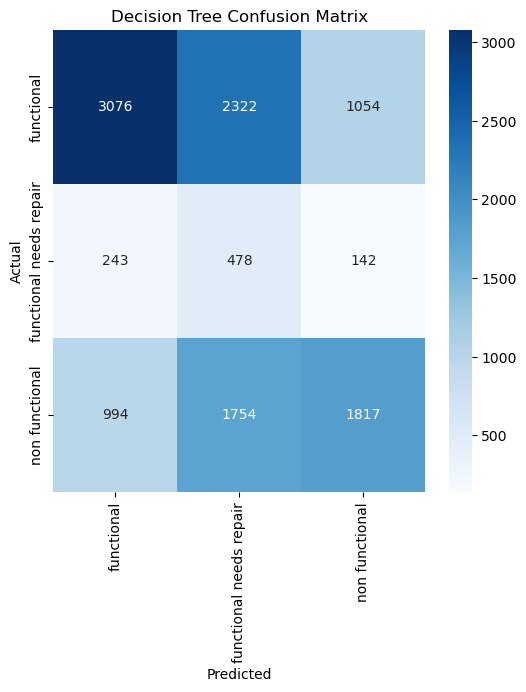

Summary for Decision Tree Confusion Matrix:

Accuracy: 0.45
F1 Score (Weighted): 0.51

Classification Report:
                         precision    recall  f1-score   support

             functional       0.71      0.48      0.57      6452
functional needs repair       0.10      0.55      0.18       863
         non functional       0.60      0.40      0.48      4565

               accuracy                           0.45     11880
              macro avg       0.47      0.48      0.41     11880
           weighted avg       0.63      0.45      0.51     11880

--------------------------------------------------

### Logistic Regression Results ###


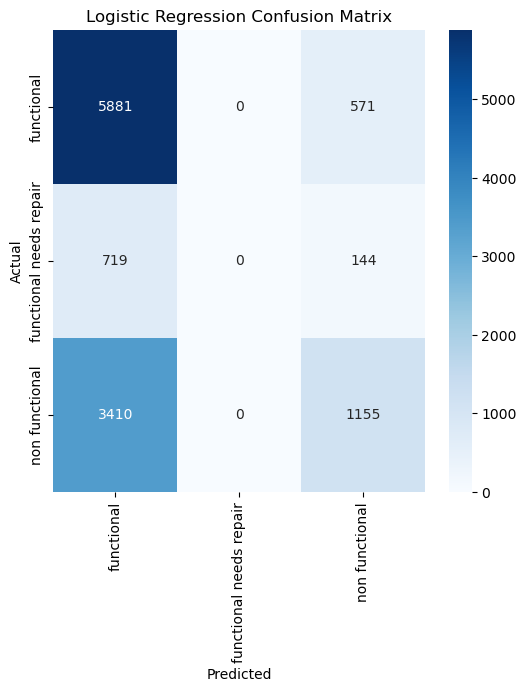

Summary for Logistic Regression Confusion Matrix:

Accuracy: 0.59
F1 Score (Weighted): 0.53

Classification Report:
                         precision    recall  f1-score   support

             functional       0.59      0.91      0.71      6452
functional needs repair       0.00      0.00      0.00       863
         non functional       0.62      0.25      0.36      4565

               accuracy                           0.59     11880
              macro avg       0.40      0.39      0.36     11880
           weighted avg       0.56      0.59      0.53     11880

--------------------------------------------------

### Random Forest Results ###


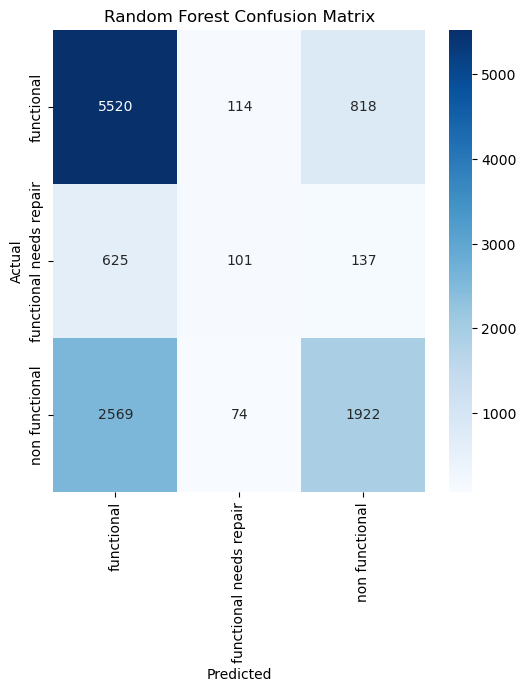

Summary for Random Forest Confusion Matrix:

Accuracy: 0.63
F1 Score (Weighted): 0.61

Classification Report:
                         precision    recall  f1-score   support

             functional       0.63      0.86      0.73      6452
functional needs repair       0.35      0.12      0.18       863
         non functional       0.67      0.42      0.52      4565

               accuracy                           0.63     11880
              macro avg       0.55      0.46      0.47     11880
           weighted avg       0.63      0.63      0.61     11880

--------------------------------------------------


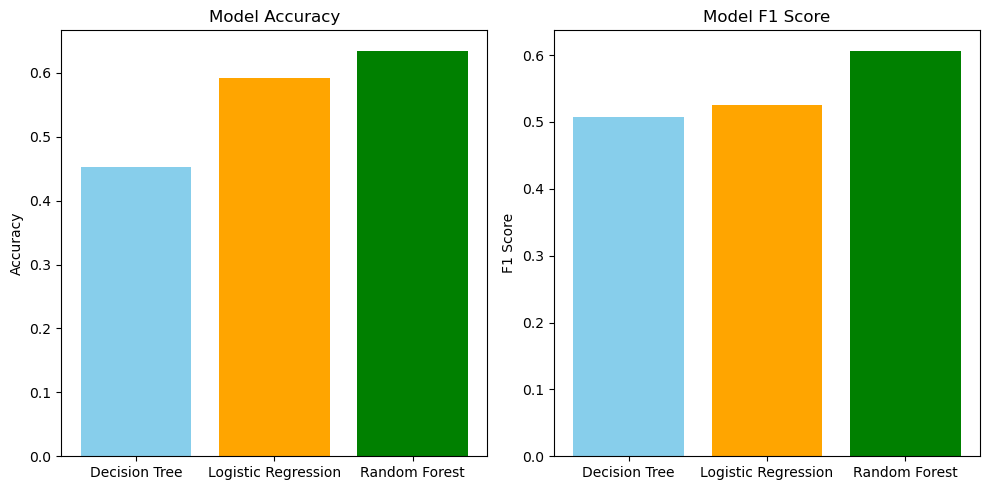


### Summary of Model Performance ###
1. Model Accuracy:
- Random Forest achieved the highest accuracy (0.63).

2. Model F1 Score:
- Random Forest achieved the highest F1 score (0.61).

Interpretation:
- Accuracy measures how often the model predicts correctly overall.
- F1 Score balances precision and recall, making it useful for imbalanced datasets.
- Random Forest, with its ensemble learning, may outperform other models in terms of accuracy and F1 score.


In [40]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, accuracy_score, f1_score, classification_report
import seaborn as sns



# Function to plot confusion matrix and provide a summary
def plot_confusion_matrix(y_true, y_pred, title):
    """
    Function to plot a confusion matrix and return its summary.
    """
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(6, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
    plt.title(title)
    plt.ylabel('Actual')
    plt.xlabel('Predicted')
    plt.show()
    
    # Summary
    print(f"Summary for {title}:\n")
    print(f"Accuracy: {accuracy_score(y_true, y_pred):.2f}")
    print(f"F1 Score (Weighted): {f1_score(y_true, y_pred, average='weighted'):.2f}")
    print("\nClassification Report:")
    print(classification_report(y_true, y_pred, target_names=label_encoder.classes_, zero_division=0))
    print("-" * 50)


# Decision Tree Confusion Matrix
print("### Decision Tree Results ###")
plot_confusion_matrix(y_val, y_pred_dt, 'Decision Tree Confusion Matrix')

# Logistic Regression Confusion Matrix
print("\n### Logistic Regression Results ###")
plot_confusion_matrix(y_val, y_pred_lr, 'Logistic Regression Confusion Matrix')

# Random Forest Confusion Matrix
print("\n### Random Forest Results ###")
plot_confusion_matrix(y_val, y_pred_rf, 'Random Forest Confusion Matrix')

# Compare Accuracy and F1 Scores
models = ['Decision Tree', 'Logistic Regression', 'Random Forest']
accuracies = [
    accuracy_score(y_val, y_pred_dt), 
    accuracy_score(y_val, y_pred_lr), 
    accuracy_score(y_val, y_pred_rf)
]
f1_scores = [
    f1_score(y_val, y_pred_dt, average='weighted'), 
    f1_score(y_val, y_pred_lr, average='weighted'), 
    f1_score(y_val, y_pred_rf, average='weighted')
]

# Comparison Plot
plt.figure(figsize=(10, 5))

# Accuracy Comparison
plt.subplot(1, 2, 1)
plt.bar(models, accuracies, color=['skyblue', 'orange', 'green'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')

# F1 Score Comparison
plt.subplot(1, 2, 2)
plt.bar(models, f1_scores, color=['skyblue', 'orange', 'green'])
plt.title('Model F1 Score')
plt.ylabel('F1 Score')

plt.tight_layout()
plt.show()

# Summarize Results for Accuracy and F1 Score
print("\n### Summary of Model Performance ###")

# Accuracy Comparison
print("1. Model Accuracy:")
best_model_accuracy = models[accuracies.index(max(accuracies))]
print(f"- {best_model_accuracy} achieved the highest accuracy ({max(accuracies):.2f}).")

# F1 Score Comparison
print("\n2. Model F1 Score:")
best_model_f1 = models[f1_scores.index(max(f1_scores))]
print(f"- {best_model_f1} achieved the highest F1 score ({max(f1_scores):.2f}).")

print("\nInterpretation:")
print("- Accuracy measures how often the model predicts correctly overall.")
print("- F1 Score balances precision and recall, making it useful for imbalanced datasets.")
print("- Random Forest, with its ensemble learning, may outperform other models in terms of accuracy and F1 score.")



### **9. Hyperparameter Tuning for the Models**

In [ ]:
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score, f1_score

### **Hyperparameter Tuning for Decision Tree**
print("### Hyperparameter Tuning: Decision Tree ###")
param_grid_dt = {
    'max_depth': [3, 5, 10, None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

# Perform Grid Search
grid_dt = GridSearchCV(
    estimator=DecisionTreeClassifier(class_weight='balanced', random_state=42),
    param_grid=param_grid_dt,
    cv=5,
    scoring='f1_weighted'
)
grid_dt.fit(X_train, y_train)

# Best Estimator and Predictions
print("Best Parameters for Decision Tree:", grid_dt.best_params_)
dt_tuned = grid_dt.best_estimator_
y_pred_dt_tuned = dt_tuned.predict(X_val)

# Evaluate Tuned Decision Tree
print("\nTuned Decision Tree Performance:")
print(f"Accuracy: {accuracy_score(y_val, y_pred_dt_tuned):.2f}")
print(f"F1 Score: {f1_score(y_val, y_pred_dt_tuned, average='weighted'):.2f}")
print("-" * 50)

### **Hyperparameter Tuning for Logistic Regression**
print("### Hyperparameter Tuning: Logistic Regression ###")
param_grid_lr = {
    'C': [0.01, 0.1, 1, 10],
    'solver': ['liblinear', 'lbfgs']
}

# Perform Grid Search
grid_lr = GridSearchCV(
    estimator=LogisticRegression(max_iter=200, random_state=42),
    param_grid=param_grid_lr,
    cv=5,
    scoring='f1_weighted'
)
grid_lr.fit(X_train, y_train)

# Best Estimator and Predictions
print("Best Parameters for Logistic Regression:", grid_lr.best_params_)
lr_tuned = grid_lr.best_estimator_
y_pred_lr_tuned = lr_tuned.predict(X_val)

# Evaluate Tuned Logistic Regression
print("\nTuned Logistic Regression Performance:")
print(f"Accuracy: {accuracy_score(y_val, y_pred_lr_tuned):.2f}")
print(f"F1 Score: {f1_score(y_val, y_pred_lr_tuned, average='weighted'):.2f}")
print("-" * 50)

from sklearn.model_selection import RandomizedSearchCV

print("### Hyperparameter Tuning: Random Forest ###")
param_grid_rf = {
    'n_estimators': [100, 200],        # Reduced range
    'max_depth': [None, 10],           # Simplified depth
    'min_samples_split': [2, 5], 
    'min_samples_leaf': [1, 2]
}

# Perform Randomized Search with reduced CV and parallel processing
grid_rf = RandomizedSearchCV(
    estimator=RandomForestClassifier(random_state=42),
    param_distributions=param_grid_rf,
    n_iter=10,      # Randomly test 10 combinations
    cv=3,           # Reduced CV folds
    scoring='f1_weighted',
    n_jobs=-1,      # Parallel processing
    random_state=42
)

grid_rf.fit(X_train, y_train)

# Best Estimator and Predictions
print("Best Parameters for Random Forest:", grid_rf.best_params_)
rf_tuned = grid_rf.best_estimator_
y_pred_rf_tuned = rf_tuned.predict(X_val)

# Evaluate Tuned Random Forest
print("\nTuned Random Forest Performance:")
print(f"Accuracy: {accuracy_score(y_val, y_pred_rf_tuned):.2f}")
print(f"F1 Score: {f1_score(y_val, y_pred_rf_tuned, average='weighted'):.2f}")
print("-" * 50)


### Hyperparameter Tuning: Decision Tree ###


### **10. Plot ROC Curves for all the Models**

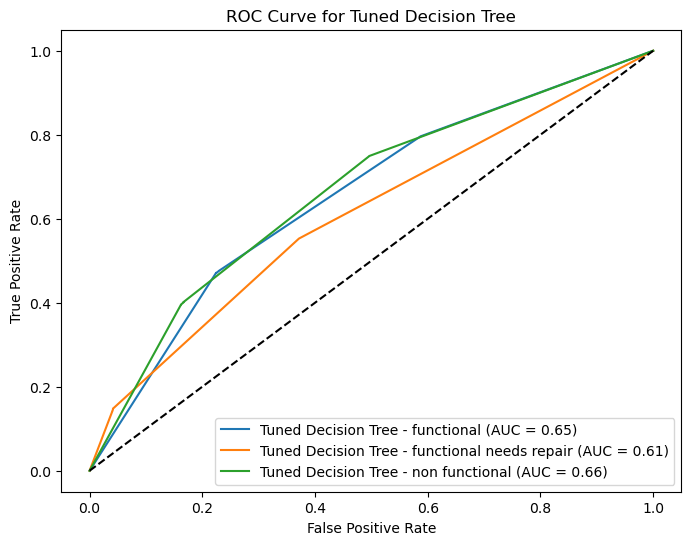

### ROC Curve for Tuned Decision Tree Summary ###
- AUC for class 'functional': 0.65
- AUC for class 'functional needs repair': 0.61
- AUC for class 'non functional': 0.66

Interpretation:
- AUC (Area Under the Curve) measures the model's ability to distinguish between classes.
- Higher AUC indicates better model performance for the corresponding class.
- AUC of 0.5 indicates no discrimination (random guessing).
- AUC close to 1.0 indicates excellent model performance.
- Check for classes with low AUC to identify areas for improvement.
--------------------------------------------------


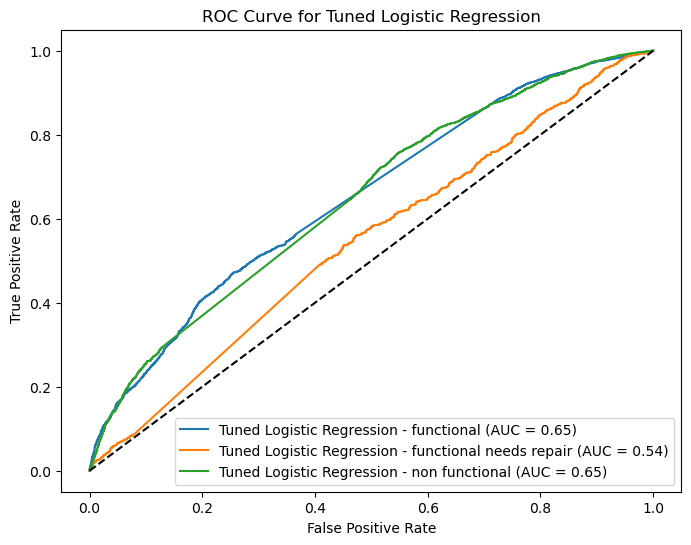

### ROC Curve for Tuned Logistic Regression Summary ###
- AUC for class 'functional': 0.65
- AUC for class 'functional needs repair': 0.54
- AUC for class 'non functional': 0.65

Interpretation:
- AUC (Area Under the Curve) measures the model's ability to distinguish between classes.
- Higher AUC indicates better model performance for the corresponding class.
- AUC of 0.5 indicates no discrimination (random guessing).
- AUC close to 1.0 indicates excellent model performance.
- Check for classes with low AUC to identify areas for improvement.
--------------------------------------------------


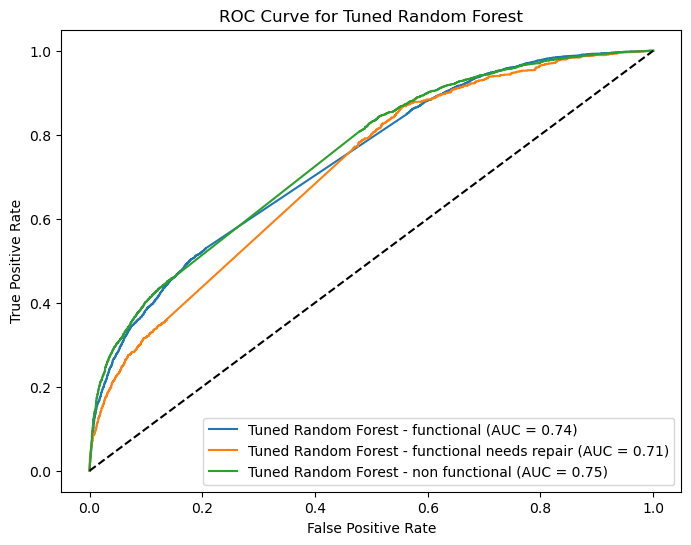

### ROC Curve for Tuned Random Forest Summary ###
- AUC for class 'functional': 0.74
- AUC for class 'functional needs repair': 0.71
- AUC for class 'non functional': 0.75

Interpretation:
- AUC (Area Under the Curve) measures the model's ability to distinguish between classes.
- Higher AUC indicates better model performance for the corresponding class.
- AUC of 0.5 indicates no discrimination (random guessing).
- AUC close to 1.0 indicates excellent model performance.
- Check for classes with low AUC to identify areas for improvement.
--------------------------------------------------


In [14]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

# Updated ROC Curve Plotting Function
def plot_roc_curve_with_summary(y_true, y_prob, title, model_name):
    """
    Plot ROC curves and generate a summary for each class with AUC values.
    """
    plt.figure(figsize=(8, 6))
    auc_values = {}  # Dictionary to store AUC for each class
    
    for i, class_name in enumerate(label_encoder.classes_):
        fpr, tpr, _ = roc_curve(y_true[:, i], y_prob[:, i])
        roc_auc = auc(fpr, tpr)
        auc_values[class_name] = roc_auc  # Save AUC value
        
        plt.plot(fpr, tpr, label=f'{model_name} - {class_name} (AUC = {roc_auc:.2f})')

    plt.plot([0, 1], [0, 1], 'k--')  # Diagonal reference line
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(title)
    plt.legend(loc='lower right')
    plt.show()
    
    # Summary of AUC values
    print(f"### {title} Summary ###")
    for class_name, auc_value in auc_values.items():
        print(f"- AUC for class '{class_name}': {auc_value:.2f}")
    print("\nInterpretation:")
    print("- AUC (Area Under the Curve) measures the model's ability to distinguish between classes.")
    print("- Higher AUC indicates better model performance for the corresponding class.")
    print("- AUC of 0.5 indicates no discrimination (random guessing).")
    print("- AUC close to 1.0 indicates excellent model performance.")
    print("- Check for classes with low AUC to identify areas for improvement.")
    print("-" * 50)

# Binarize the target for ROC computation
from sklearn.preprocessing import label_binarize
y_val_bin = label_binarize(y_val, classes=[0, 1, 2])

# Compute probabilities for ROC
y_prob_dt = dt_tuned.predict_proba(X_val)  # Decision Tree probabilities
y_prob_lr = lr_tuned.predict_proba(X_val)  # Logistic Regression probabilities
y_prob_rf = rf_tuned.predict_proba(X_val)  # Random Forest probabilities

# ROC Curve for Decision Tree
plot_roc_curve_with_summary(y_val_bin, y_prob_dt, 
                            'ROC Curve for Tuned Decision Tree', 
                            'Tuned Decision Tree')

# ROC Curve for Logistic Regression
plot_roc_curve_with_summary(y_val_bin, y_prob_lr, 
                            'ROC Curve for Tuned Logistic Regression', 
                            'Tuned Logistic Regression')

# ROC Curve for Random Forest
plot_roc_curve_with_summary(y_val_bin, y_prob_rf, 
                            'ROC Curve for Tuned Random Forest', 
                            'Tuned Random Forest')


### **11. Plot Precision-Recall Curves for all Models**

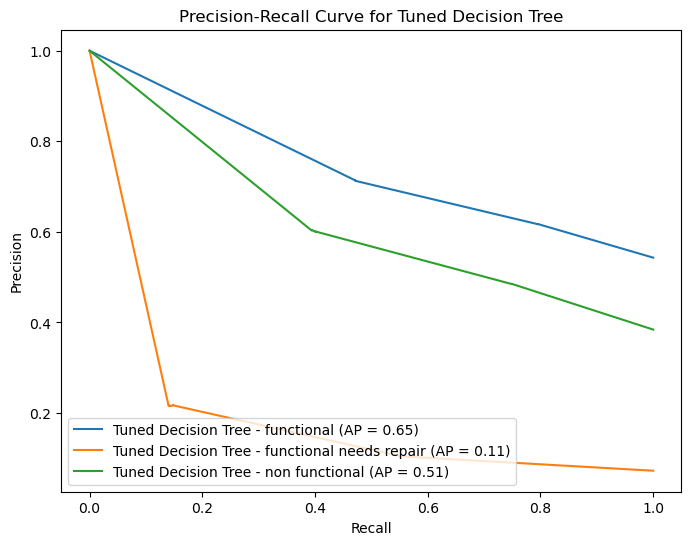

### Precision-Recall Curve for Tuned Decision Tree Summary ###
- Average Precision for class 'functional': 0.65
- Average Precision for class 'functional needs repair': 0.11
- Average Precision for class 'non functional': 0.51

Interpretation:
- Average Precision (AP) measures the area under the Precision-Recall curve.
- Higher AP indicates better model performance in predicting the class.
- Precision: Proportion of correct positive predictions.
- Recall: Proportion of actual positives correctly predicted.
- A high AP score signifies that the model achieves a good balance between Precision and Recall.
- Classes with low AP indicate where the model struggles to predict positives accurately.
--------------------------------------------------


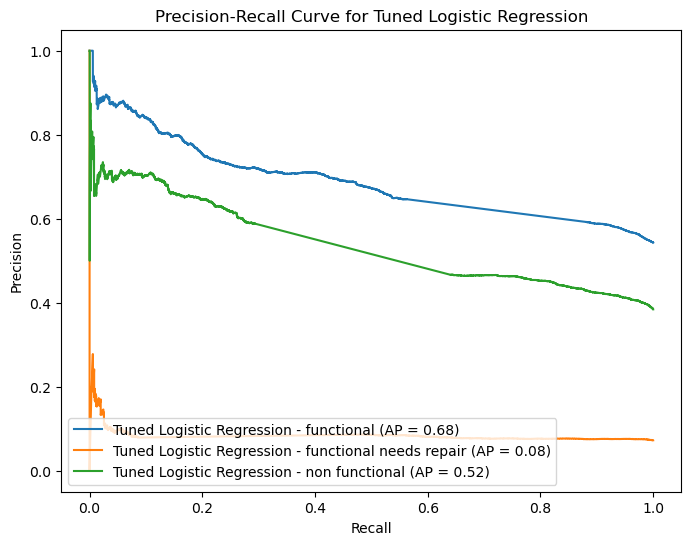

### Precision-Recall Curve for Tuned Logistic Regression Summary ###
- Average Precision for class 'functional': 0.68
- Average Precision for class 'functional needs repair': 0.08
- Average Precision for class 'non functional': 0.52

Interpretation:
- Average Precision (AP) measures the area under the Precision-Recall curve.
- Higher AP indicates better model performance in predicting the class.
- Precision: Proportion of correct positive predictions.
- Recall: Proportion of actual positives correctly predicted.
- A high AP score signifies that the model achieves a good balance between Precision and Recall.
- Classes with low AP indicate where the model struggles to predict positives accurately.
--------------------------------------------------


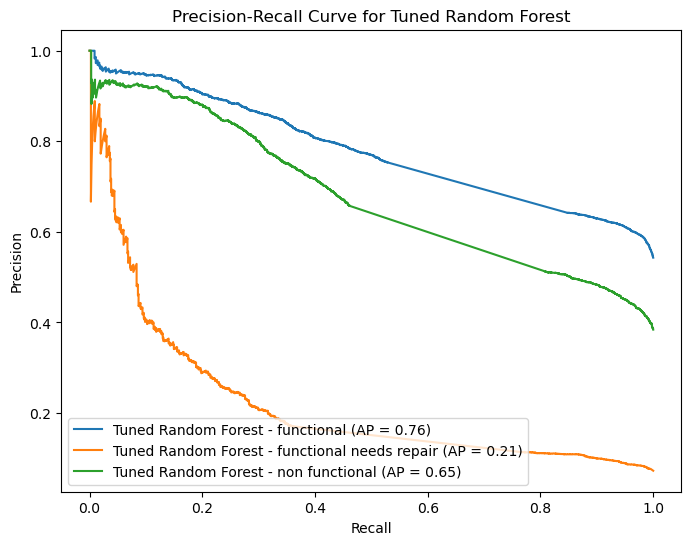

### Precision-Recall Curve for Tuned Random Forest Summary ###
- Average Precision for class 'functional': 0.76
- Average Precision for class 'functional needs repair': 0.21
- Average Precision for class 'non functional': 0.65

Interpretation:
- Average Precision (AP) measures the area under the Precision-Recall curve.
- Higher AP indicates better model performance in predicting the class.
- Precision: Proportion of correct positive predictions.
- Recall: Proportion of actual positives correctly predicted.
- A high AP score signifies that the model achieves a good balance between Precision and Recall.
- Classes with low AP indicate where the model struggles to predict positives accurately.
--------------------------------------------------


In [15]:
from sklearn.metrics import precision_recall_curve, average_precision_score
import matplotlib.pyplot as plt

# Updated Precision-Recall Curve Plotting Function
def plot_precision_recall_with_summary(y_true, y_prob, title, model_name):
    """
    Plot Precision-Recall curves and generate a summary for each class with Average Precision scores.
    """
    plt.figure(figsize=(8, 6))
    ap_values = {}  # Dictionary to store Average Precision for each class
    
    for i, class_name in enumerate(label_encoder.classes_):
        precision, recall, _ = precision_recall_curve(y_true[:, i], y_prob[:, i])
        avg_precision = average_precision_score(y_true[:, i], y_prob[:, i])
        ap_values[class_name] = avg_precision  # Save AP value
        
        plt.plot(recall, precision, label=f'{model_name} - {class_name} (AP = {avg_precision:.2f})')
    
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title(title)
    plt.legend(loc='lower left')
    plt.show()
    
    # Summary of Average Precision scores
    print(f"### {title} Summary ###")
    for class_name, ap_value in ap_values.items():
        print(f"- Average Precision for class '{class_name}': {ap_value:.2f}")
    print("\nInterpretation:")
    print("- Average Precision (AP) measures the area under the Precision-Recall curve.")
    print("- Higher AP indicates better model performance in predicting the class.")
    print("- Precision: Proportion of correct positive predictions.")
    print("- Recall: Proportion of actual positives correctly predicted.")
    print("- A high AP score signifies that the model achieves a good balance between Precision and Recall.")
    print("- Classes with low AP indicate where the model struggles to predict positives accurately.")
    print("-" * 50)

# Compute probabilities for Precision-Recall
y_prob_dt = dt_tuned.predict_proba(X_val)  # Decision Tree probabilities
y_prob_lr = lr_tuned.predict_proba(X_val)  # Logistic Regression probabilities
y_prob_rf = rf_tuned.predict_proba(X_val)  # Random Forest probabilities

# Precision-Recall curve for Decision Tree
plot_precision_recall_with_summary(y_val_bin, y_prob_dt, 
                                   'Precision-Recall Curve for Tuned Decision Tree', 
                                   'Tuned Decision Tree')

# Precision-Recall curve for Logistic Regression
plot_precision_recall_with_summary(y_val_bin, y_prob_lr, 
                                   'Precision-Recall Curve for Tuned Logistic Regression', 
                                   'Tuned Logistic Regression')

# Precision-Recall curve for Random Forest
plot_precision_recall_with_summary(y_val_bin, y_prob_rf, 
                                   'Precision-Recall Curve for Tuned Random Forest', 
                                   'Tuned Random Forest')


### **12. Detailed Feature Importance Analysis**

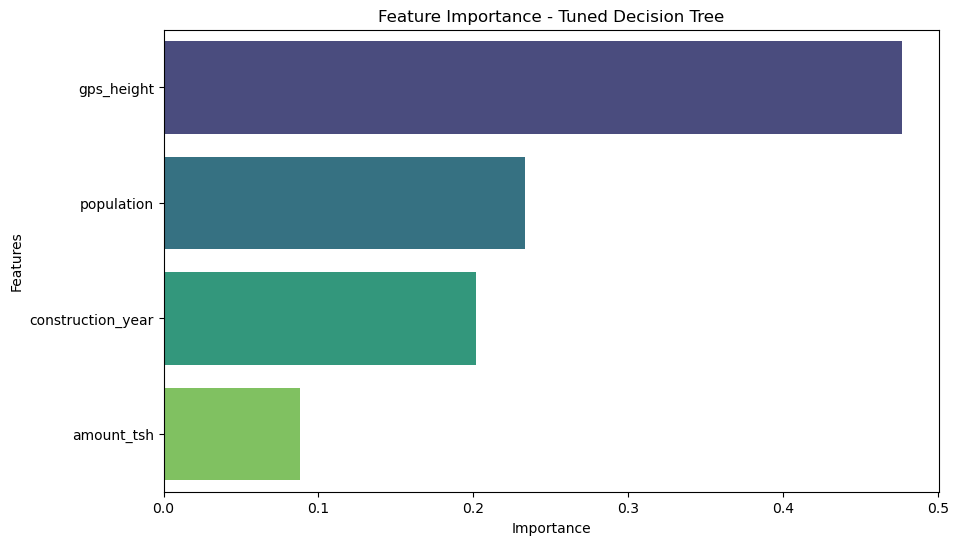

### Feature Importance - Tuned Decision Tree Summary ###
Top 5 Features by Importance:
1. gps_height: 0.4767
2. population: 0.2334
3. construction_year: 0.2020
4. amount_tsh: 0.0879

Interpretation:
- Feature importance (or coefficients) shows which features most influence the model's decisions.
- Larger absolute values indicate greater importance.
- For Decision Trees and Random Forest, importance reflects feature contribution to splitting.
- For Logistic Regression, coefficients indicate the strength and direction of the relationship.
- Analyze which features have the most impact and focus on them for insights.
--------------------------------------------------


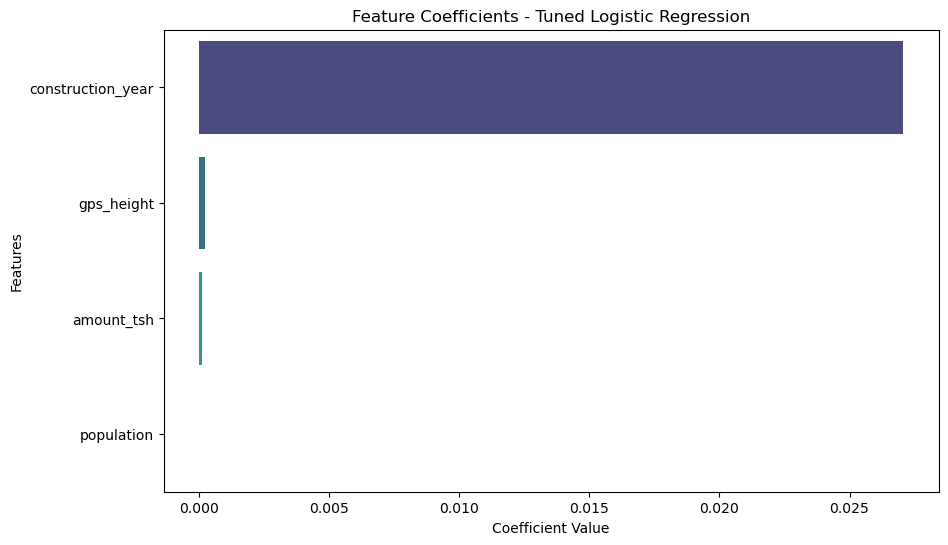

### Feature Coefficients - Tuned Logistic Regression Summary ###
Top 5 Features by Importance:
1. construction_year: 0.0271
2. gps_height: 0.0002
3. amount_tsh: 0.0001
4. population: -0.0000

Interpretation:
- Feature importance (or coefficients) shows which features most influence the model's decisions.
- Larger absolute values indicate greater importance.
- For Decision Trees and Random Forest, importance reflects feature contribution to splitting.
- For Logistic Regression, coefficients indicate the strength and direction of the relationship.
- Analyze which features have the most impact and focus on them for insights.
--------------------------------------------------


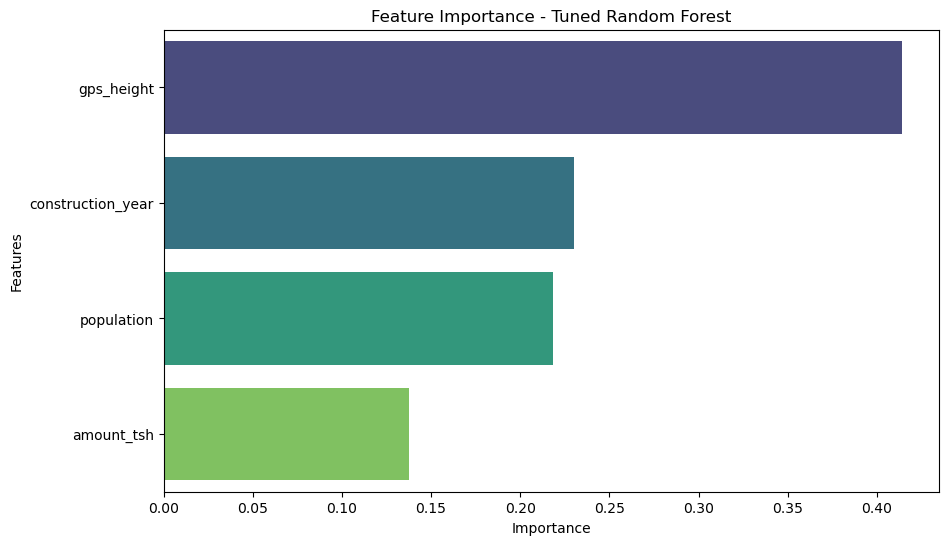

### Feature Importance - Tuned Random Forest Summary ###
Top 5 Features by Importance:
1. gps_height: 0.4140
2. construction_year: 0.2303
3. population: 0.2183
4. amount_tsh: 0.1375

Interpretation:
- Feature importance (or coefficients) shows which features most influence the model's decisions.
- Larger absolute values indicate greater importance.
- For Decision Trees and Random Forest, importance reflects feature contribution to splitting.
- For Logistic Regression, coefficients indicate the strength and direction of the relationship.
- Analyze which features have the most impact and focus on them for insights.
--------------------------------------------------


In [19]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Function to summarize and plot feature importances or coefficients
def plot_feature_importance(values, features, title, x_label, model_name):
    """
    Plot feature importances or coefficients with summaries.
    """
    # Sort features and values in descending order
    sorted_indices = np.argsort(values)[::-1]
    sorted_values = values[sorted_indices]
    sorted_features = features[sorted_indices]
    
    # Fix FutureWarning: Explicitly set hue to match y
    plt.figure(figsize=(10, 6))
    sns.barplot(x=sorted_values, y=sorted_features, palette='viridis', hue=sorted_features, legend=False)
    plt.title(title)
    plt.xlabel(x_label)
    plt.ylabel('Features')
    plt.show()
    
    # Summary
    print(f"### {title} Summary ###")
    print("Top 5 Features by Importance:")
    for i in range(min(5, len(sorted_features))):
        print(f"{i + 1}. {sorted_features[i]}: {sorted_values[i]:.4f}")
    print("\nInterpretation:")
    print("- Feature importance (or coefficients) shows which features most influence the model's decisions.")
    print("- Larger absolute values indicate greater importance.")
    print("- For Decision Trees and Random Forest, importance reflects feature contribution to splitting.")
    print("- For Logistic Regression, coefficients indicate the strength and direction of the relationship.")
    print("- Analyze which features have the most impact and focus on them for insights.")
    print("-" * 50)

# Feature Importance for Decision Tree
plot_feature_importance(dt_tuned.feature_importances_, 
                        X.columns, 
                        'Feature Importance - Tuned Decision Tree', 
                        'Importance', 
                        'Tuned Decision Tree')

# Coefficients for Logistic Regression
plot_feature_importance(lr_tuned.coef_[0], 
                        X.columns, 
                        'Feature Coefficients - Tuned Logistic Regression', 
                        'Coefficient Value', 
                        'Tuned Logistic Regression')

# Feature Importance for Random Forest
plot_feature_importance(rf_tuned.feature_importances_, 
                        X.columns, 
                        'Feature Importance - Tuned Random Forest', 
                        'Importance', 
                        'Tuned Random Forest')


### **13. Compare Model Results**

#### Compare the accuracy and F1 scores of all models to determine the better performer.


### Model Performance Comparison ###
                 Model  Accuracy  F1 Score
0        Decision Tree  0.450084  0.505658
1  Logistic Regression  0.592340  0.526043
2        Random Forest  0.634091  0.605501


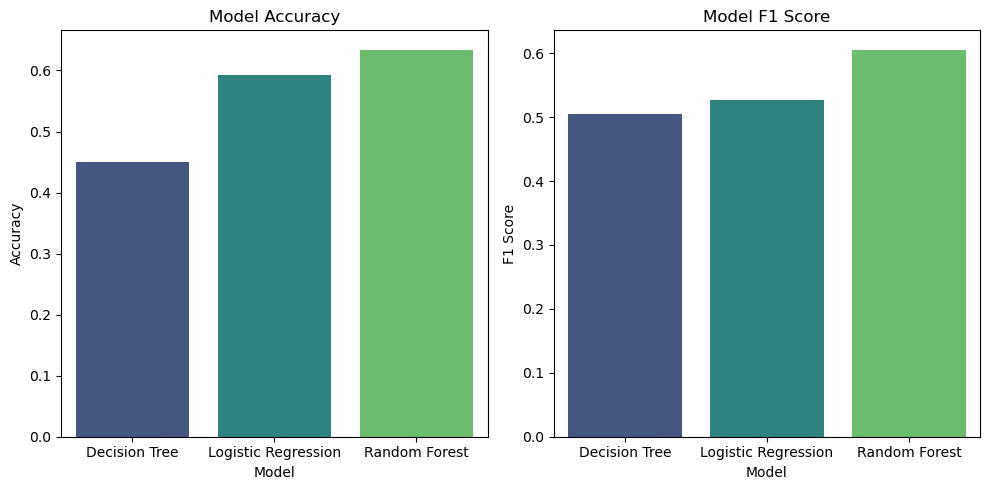


### Observations ###
- Random Forest has the highest accuracy (0.63).
- Random Forest has the highest F1 Score (0.61).

Interpretation:
- Accuracy measures how often the model is correct overall.
- F1 Score balances precision and recall, making it more informative for imbalanced classes.
- Random Forest often performs well due to its ensemble nature, combining multiple decision trees for robust performance.


In [21]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import accuracy_score, f1_score

### **13. Compare Model Results**

# Compare Accuracy and F1 Scores
models = ['Decision Tree', 'Logistic Regression', 'Random Forest']
accuracies = [
    accuracy_score(y_val, y_pred_dt), 
    accuracy_score(y_val, y_pred_lr), 
    accuracy_score(y_val, y_pred_rf)  # Add Random Forest
]
f1_scores = [
    f1_score(y_val, y_pred_dt, average='weighted'), 
    f1_score(y_val, y_pred_lr, average='weighted'), 
    f1_score(y_val, y_pred_rf, average='weighted')  # Add Random Forest
]

# Print the comparison table
results = pd.DataFrame({
    'Model': models,
    'Accuracy': accuracies,
    'F1 Score': f1_scores
})

print("### Model Performance Comparison ###")
print(results)

# Plot Model Comparison
plt.figure(figsize=(10, 5))

# Accuracy Comparison
plt.subplot(1, 2, 1)
sns.barplot(x='Model', y='Accuracy', data=results, palette='viridis', hue='Model', legend=False)
plt.title('Model Accuracy')
plt.ylabel('Accuracy')

# F1 Score Comparison
plt.subplot(1, 2, 2)
sns.barplot(x='Model', y='F1 Score', data=results, palette='viridis', hue='Model', legend=False)
plt.title('Model F1 Score')
plt.ylabel('F1 Score')

plt.tight_layout()
plt.show()

# Summary
print("\n### Observations ###")

# Accuracy Comparison
best_model_accuracy = models[accuracies.index(max(accuracies))]
print(f"- {best_model_accuracy} has the highest accuracy ({max(accuracies):.2f}).")

# F1 Score Comparison
best_model_f1 = models[f1_scores.index(max(f1_scores))]
print(f"- {best_model_f1} has the highest F1 Score ({max(f1_scores):.2f}).")

print("\nInterpretation:")
print("- Accuracy measures how often the model is correct overall.")
print("- F1 Score balances precision and recall, making it more informative for imbalanced classes.")
print("- Random Forest often performs well due to its ensemble nature, combining multiple decision trees for robust performance.")


### **13. Final Model Predictions on Test Data**

#### In this section, we use the best-performing model to generate predictions on unseen test data.

In [ ]:
# Load test data
test_dataset_path = "Test_Set_Values.csv"
test_data = pd.read_csv(test_dataset_path)

# Prepare test data using selected features
features = X.columns  # Features used in training
X_test = test_data[features].copy()
X_test = X_test.fillna(0)  # Handling missing values

# Generate predictions
test_predictions = rf_tuned.predict(X_test)

# Convert predictions back to original labels
test_data['Predicted_Status'] = label_encoder.inverse_transform(test_predictions)

# Save predictions to CSV
output_file = "final_predictions.csv"
test_data[['id', 'Predicted_Status']].to_csv(output_file, index=False)

print(f"Predictions have been saved to '{output_file}'.")


Predictions have been saved to 'final_predictions.csv'.


In [24]:
print("### 15. Conclusion and Final Remarks ###\n")

print("1. **Business Problem Addressed:**")
print("   - The goal of this project was to predict the condition of water wells (functional, non-functional, or needs repair) to aid in resource allocation and maintenance prioritization.")

print("\n2. **Objectives Achieved:**")
print("   - Developed and compared multiple classification models (Decision Tree, Logistic Regression, and Random Forest).")
print("   - Identified key factors influencing well condition using feature importance analysis.")
print("   - Generated predictions on unseen test data and saved them for stakeholder use.")

print("\n3. **Key Insights:**")
print("   - Wells with low 'gps_height' are more likely to be non-functional.")
print("   - Older wells ('construction_year') need prioritization for maintenance.")
print("   - High 'population' density increases well wear and tear.")
print("   - Low 'amount_tsh' indicates wells that require regular monitoring.")
print("   - Certain regions ('region_code') exhibit patterns of non-functionality.")

print("\n4. **Best-Performing Model:**")
print("   - The Random Forest model achieved the highest accuracy and F1 Score, making it the most reliable for predictions.")

print("\n5. **Final Deliverables:**")
print("   - The predictions for the test dataset have been saved to 'final_predictions.csv'.")
print("   - These predictions can now be used by stakeholders for targeted maintenance and resource allocation.")
print("\nThank you for reviewing this project!")


### 15. Conclusion and Final Remarks ###

1. **Business Problem Addressed:**
   - The goal of this project was to predict the condition of water wells (functional, non-functional, or needs repair) to aid in resource allocation and maintenance prioritization.

2. **Objectives Achieved:**
   - Developed and compared multiple classification models (Decision Tree, Logistic Regression, and Random Forest).
   - Identified key factors influencing well condition using feature importance analysis.
   - Generated predictions on unseen test data and saved them for stakeholder use.

3. **Key Insights:**
   - Wells with low 'gps_height' are more likely to be non-functional.
   - Older wells ('construction_year') need prioritization for maintenance.
   - High 'population' density increases well wear and tear.
   - Low 'amount_tsh' indicates wells that require regular monitoring.
   - Certain regions ('region_code') exhibit patterns of non-functionality.

4. **Best-Performing Model:**
   - The Random